# **Happy Customers**
---

# Setup

In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data from a CSV file
dataset = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Extract the input features (x) and output (y) from the dataset
x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Split the data into training and testing sets
random_state = 137
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)

# Exploratory Data Analysis

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64


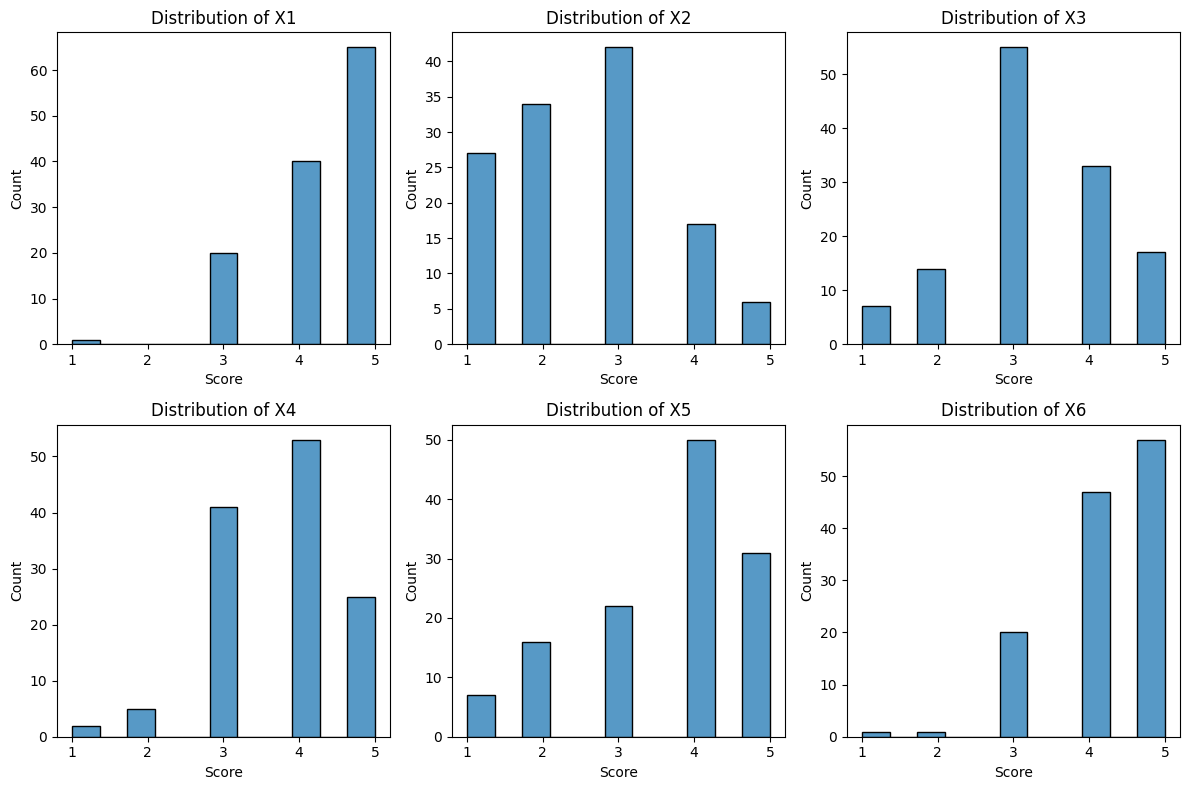

In [3]:
# Create a DataFrame with the feature columns
df_features = pd.DataFrame(x, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

# Check for missing values in the dataset
missing_values = dataset.isnull().sum()

# Print the missing values count for each column
print(missing_values)

# Plot the distribution of scores for each feature
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(df_features.columns):
    sns.histplot(df_features[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Outlier Detection - IQR (Interquartile Range)

Number of outliers: 17


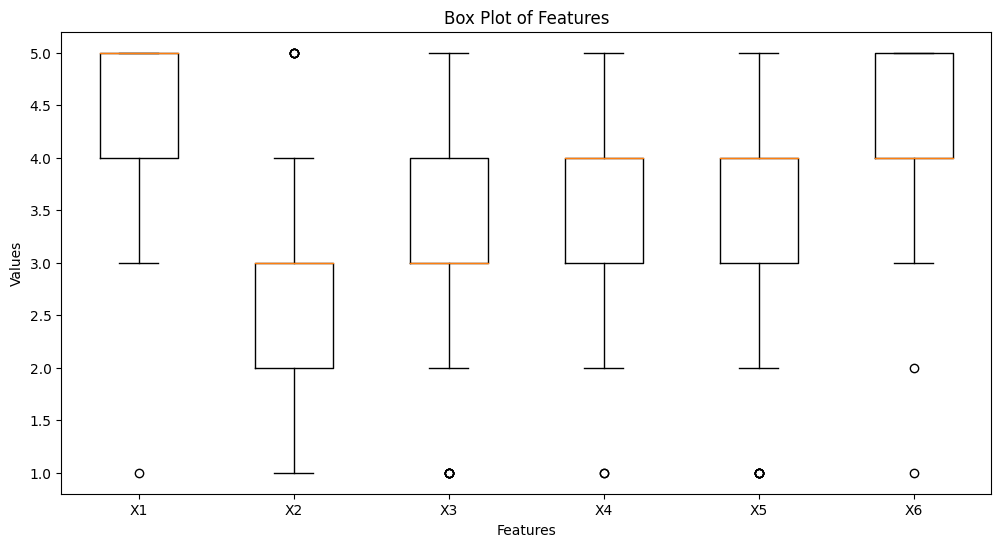

In [29]:
# Calculate the IQR
Q1 = np.percentile(x, 25, axis=0)
Q3 = np.percentile(x, 75, axis=0)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5

# Find outliers
lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR
outliers = ((x < lower_bound) | (x > upper_bound)).any(axis=1)

# Count the number of outliers
num_outliers = sum(outliers)
print("Number of outliers:", num_outliers)


# Create box plots for each feature
plt.figure(figsize=(12, 6))
plt.boxplot(x)
plt.xticks(range(1, len(dataset.columns)), dataset.columns[1:])
plt.xlabel("Features")
plt.ylabel("Values")
plt.title("Box Plot of Features")
plt.show()

### Correlation Matrix

If the correlation between features is 0.85 or above, it will be highlighted in yellow.

In [32]:
# Calculate the correlation matrix
corr_matrix = dataset.iloc[:, 1:].corr()

# Highlight correlations above the threshold
corr_styled = corr_matrix.style.applymap(lambda x: 'background-color: yellow' if abs(x) >= 0.85 else '')

# Display the styled correlation matrix
corr_styled

,X1,X2,X3,X4,X5,X6
X1,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


# Initial Modelling

In [5]:
def runModels(models, model_names, x_train, x_test, y_train, y_test):
    # Create subplots for confusion matrices and ROC curves
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    # Iterate over models
    for i, model in enumerate(models):
        # Train the model
        model.fit(x_train, y_train)
        
        # Make predictions
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1]
        
        # Calculate scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix - OLD
        #sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axes[0, i])
        #axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
        #axes[0, i].set_xlabel('Predicted Labels')
        #axes[0, i].set_ylabel('True Labels')
        
        plot_confusion_matrix(model, x_test, y_test, ax=axes[0, i])
        axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axes[1, i].plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
        axes[1, i].plot([0, 1], [0, 1], 'k--')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('False Positive Rate')
        axes[1, i].set_ylabel('True Positive Rate')
        axes[1, i].set_title(f'{model_names[i]} ROC Curve')
        axes[1, i].legend(loc='lower right')
        axes[1, i].text(0.5, -0.25, f'Accuracy: {accuracy:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.30, f'Precision: {precision:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.35, f'Recall: {recall:.2f}', transform=axes[1, i].transAxes, ha='right')
        axes[1, i].text(0.5, -0.40, f'F1: {f1:.2f}', transform=axes[1, i].transAxes, ha='right')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.show()

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

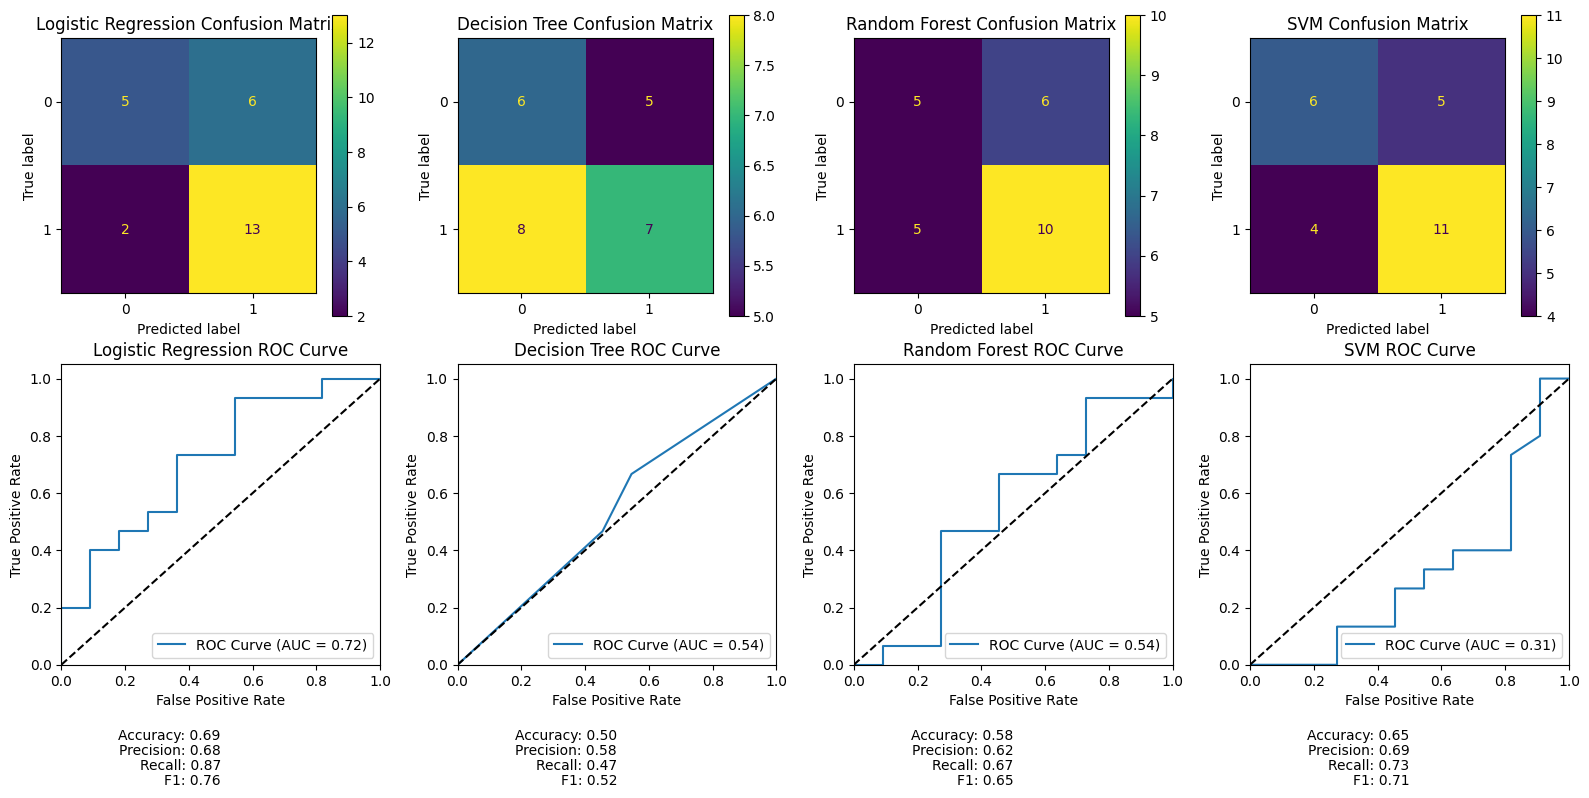

In [6]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Analysis

Initial tests with basic models result in generally low accuracy scores. Further tuning is required.

# Optimization

## Logistic Regression

### Regularization

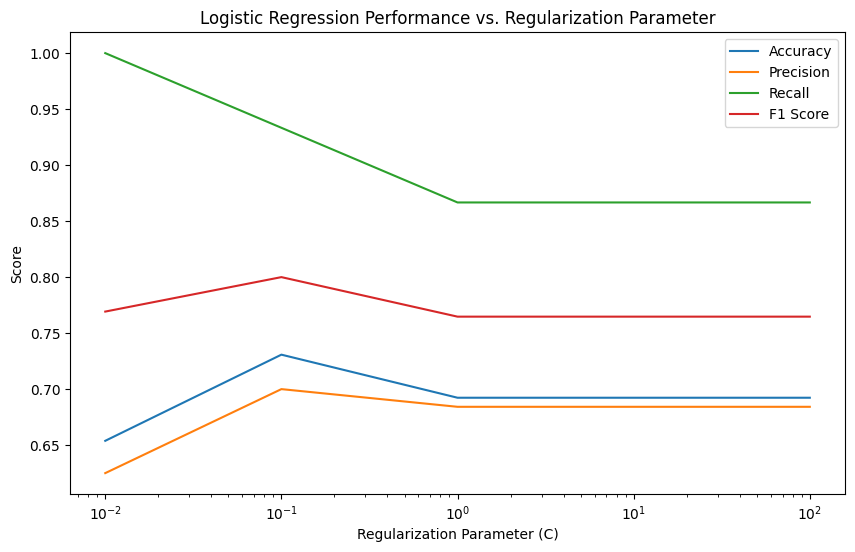

In [7]:
# Define a list of regularization parameters to evaluate
regularization_params = [0.01, 0.1, 1, 10, 100]

# Initialize empty lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over regularization parameters
for C in regularization_params:
    # Create and train the logistic regression model
    model = LogisticRegression(C=C)
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)


# Plotting the evaluation metrics vs. regularization parameter
plt.figure(figsize=(10, 6))
plt.plot(regularization_params, accuracy_scores, label='Accuracy')
plt.plot(regularization_params, precision_scores, label='Precision')
plt.plot(regularization_params, recall_scores, label='Recall')
plt.plot(regularization_params, f1_scores, label='F1 Score')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs. Regularization Parameter')
plt.legend()
plt.xscale('log')
plt.show()

### Applied Regularization Parameter

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


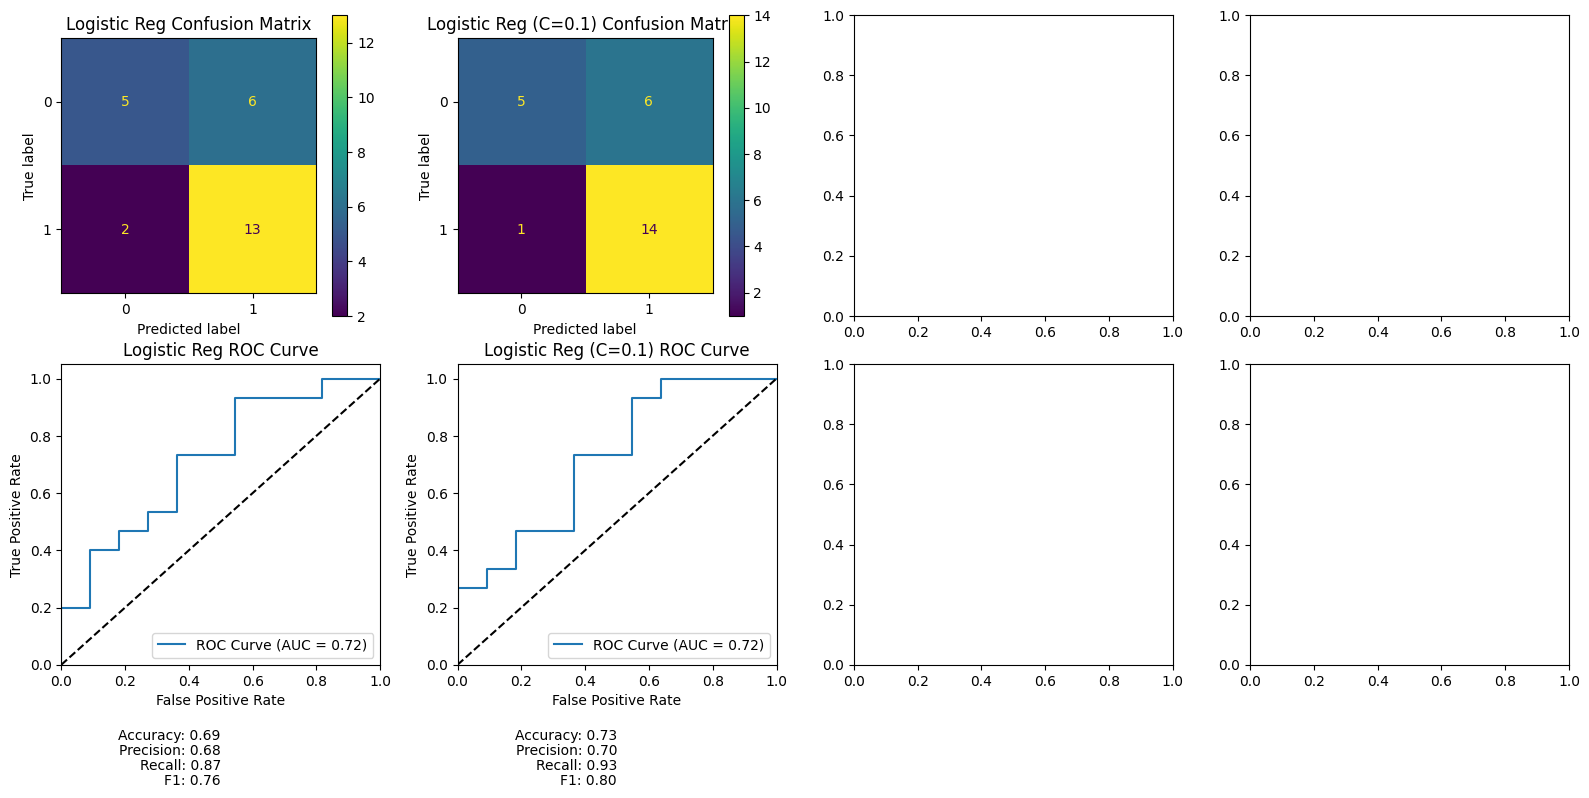

In [8]:
# Initialize the models
models = [
    LogisticRegression(),
    LogisticRegression(C=0.1)
]

# Define the model names for labeling
model_names = [
    'Logistic Reg',
    'Logistic Reg (C=0.1)'
]
runModels(models, model_names, x_train, x_test, y_train, y_test)


#### Analysis

We can determine visually that the optimal Regularization Parameter is 0.1. When applied to the LR model, Accuracy reaches the target goal of 73%.

### Feature Selection

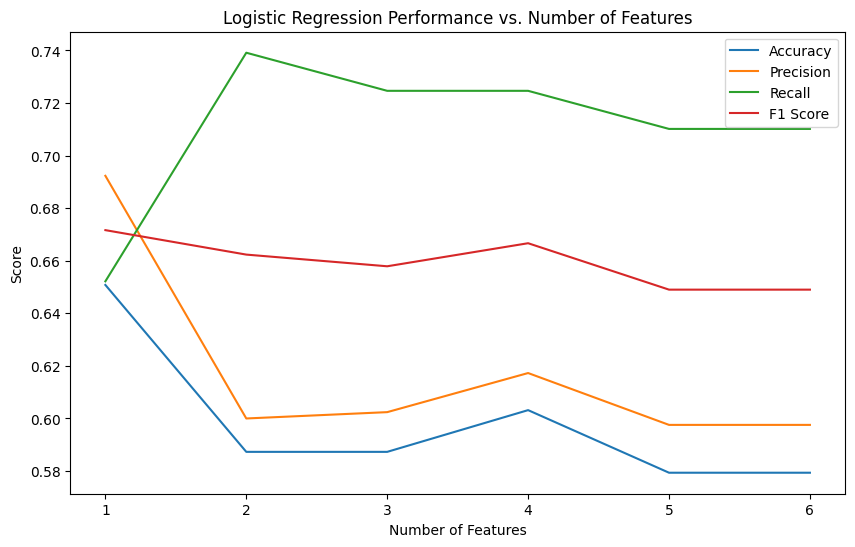

In [9]:
# Define the number of features to select
num_features = len(df_features.columns)

# Initialize empty lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different numbers of features
for k in range(1, num_features + 1):
    # Create a logistic regression model
    model = LogisticRegression()

    # Create RFE object and fit the model
    rfe = RFE(estimator=model, n_features_to_select=k)
    rfe.fit(df_features, y)

    # Select the top k features
    selected_features = df_features.columns[rfe.support_]

    # Train the model with the selected features
    model.fit(df_features[selected_features], y)

    # Make predictions on the test set
    y_pred = model.predict(df_features[selected_features])

    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plotting the evaluation metrics vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features + 1), accuracy_scores, label='Accuracy')
plt.plot(range(1, num_features + 1), precision_scores, label='Precision')
plt.plot(range(1, num_features + 1), recall_scores, label='Recall')
plt.plot(range(1, num_features + 1), f1_scores, label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Logistic Regression Performance vs. Number of Features')
plt.legend()
plt.show()

#### Analysis

This suggests that to maximize accuracy (or precision) the optimal number of features is one. Next step is to find which one is most important to keep.

Accuracy: 0.69
Precision: 0.68
Recall: 0.87
F1 Score: 0.76


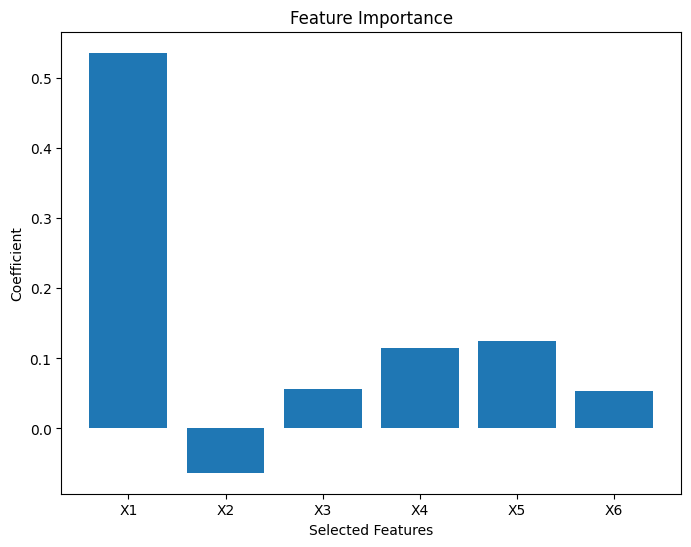

In [10]:
# Create a logistic regression model
model = LogisticRegression()

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=6)
x_train_rfe = rfe.fit_transform(x_train, y_train)
x_test_rfe = rfe.transform(x_test)

# Fit the model to the reduced feature set
model.fit(x_train_rfe, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_rfe)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Get the mask of selected features
feature_mask = rfe.support_

# Get the feature names
selected_features = df_features.columns[feature_mask]

# Plotting the feature importance
plt.figure(figsize=(8, 6))
plt.bar(selected_features, rfe.estimator_.coef_.flatten())
plt.xlabel('Selected Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.show()

### Applied RFE 1

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

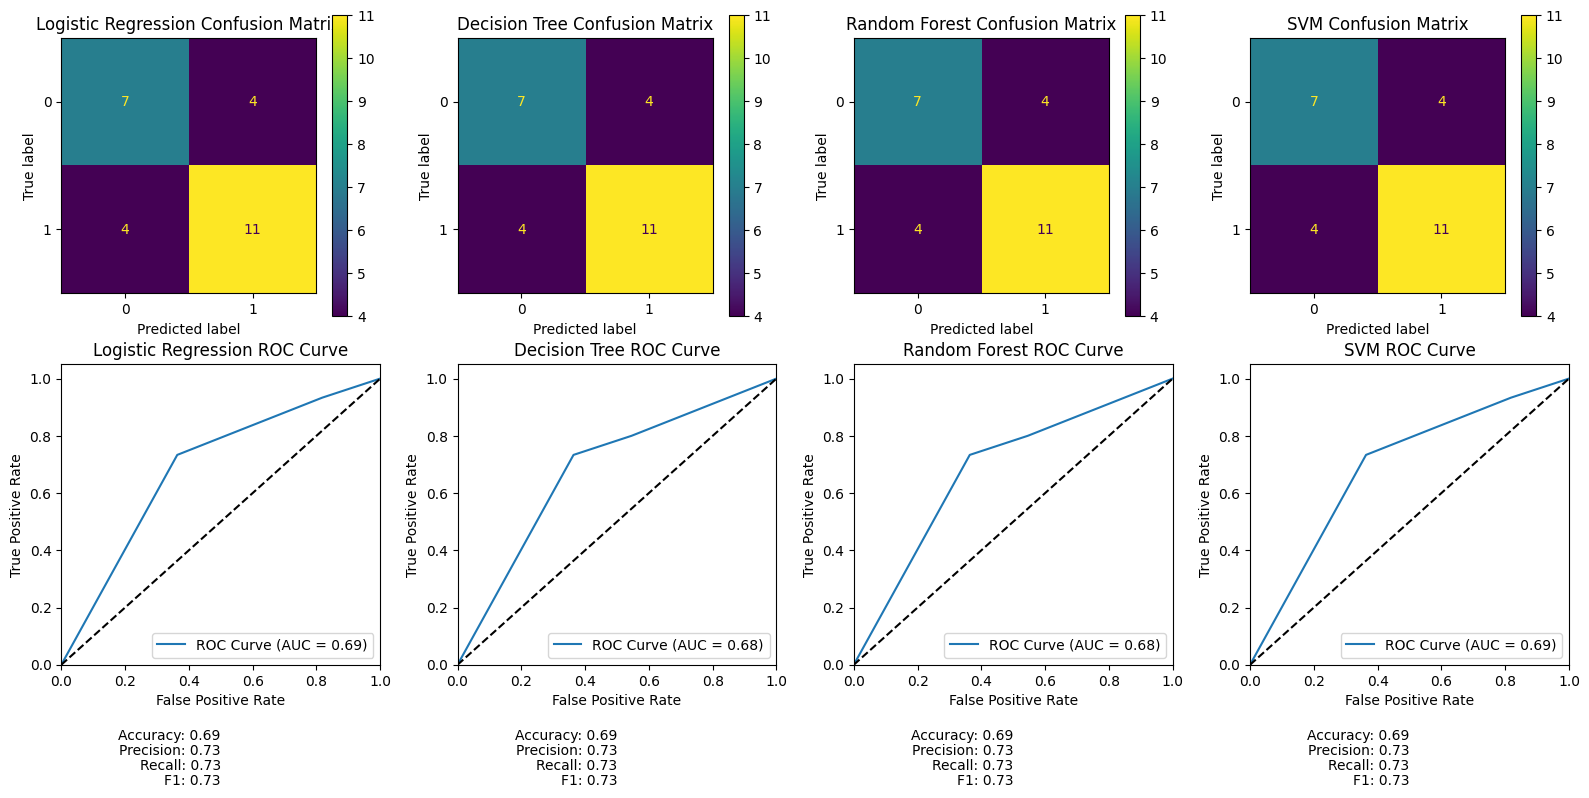

In [11]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1']
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

Basing the prediction only on X1 yields better results than including all other features into the modelling. 

**Question**: Is there danger in reducing features so heavily, even if the results improve?

### Applied RFE 2

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

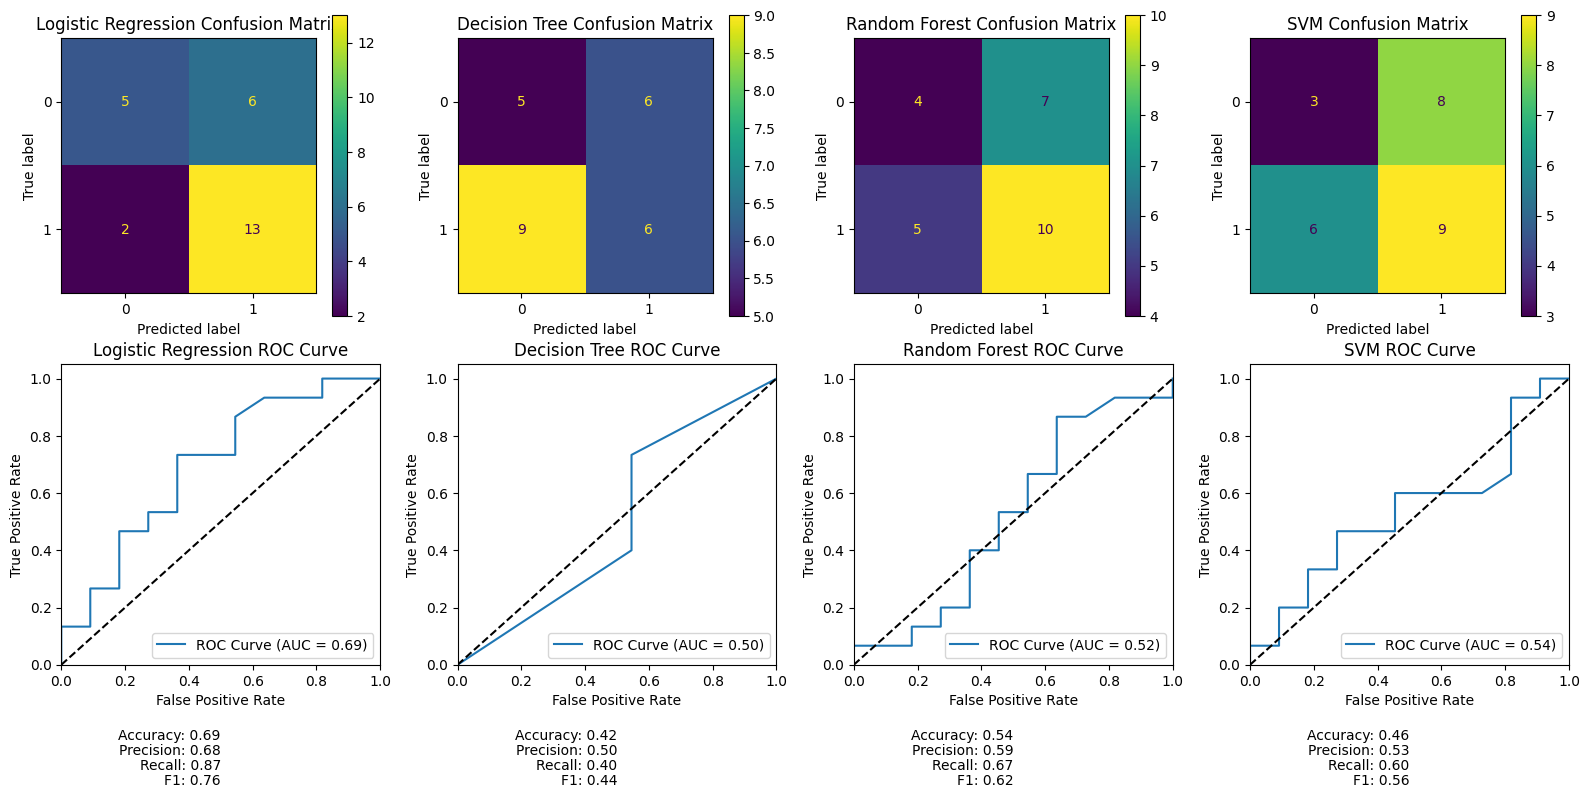

In [12]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1', 'X3', 'X4', 'X5', 'X6']
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

The LR model results when excluding X2 match the results that include X2.

- **Accuracy**: no change
- **Precision**: -0.01
- **Recall**: +0.06
- **F1**: +0.02

This confirms that X2 is not an useful factor to predicting customer happiness, and can be removed from the next survey.

### Applied RP and RFE

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

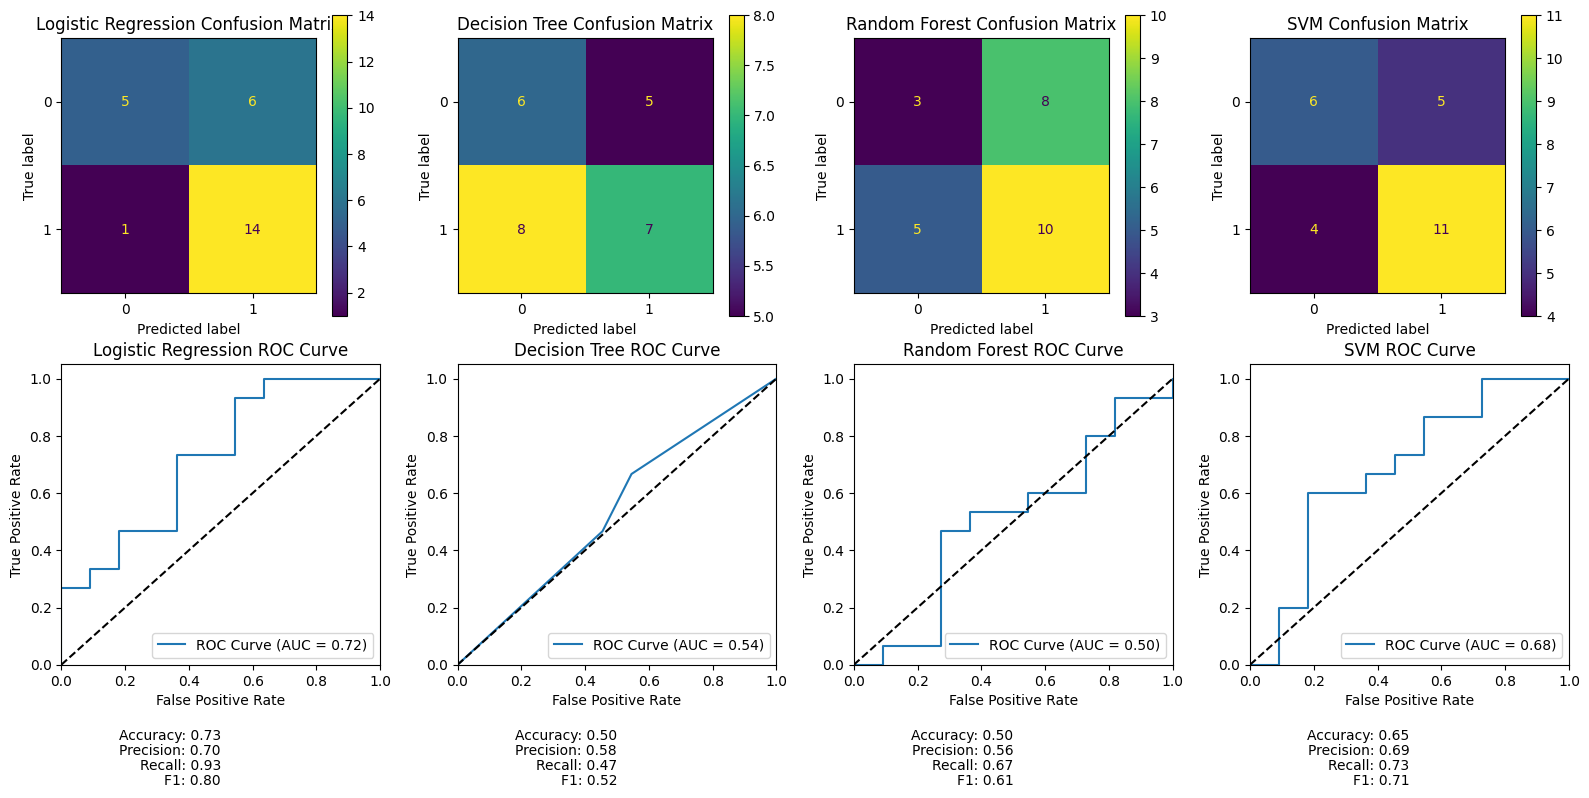

In [13]:
# Initialize the models
models = [
    LogisticRegression(C=0.1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

selected_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'] # Full
#selected_features = ['X1']
#selected_features = ['X1','X3', 'X4', 'X5', 'X6'] 
#selected_features = ['X1', 'X4', 'X5'] 
x_selected = df_features[selected_features].values
x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.20, random_state= random_state)

runModels(models, model_names, x_train_selected, x_test_selected, y_train, y_test)

#### Analysis

Once the Regularization Parameter (C) is taken into account, X2 becomes a more important factor and cannot be removed without affecting the LR model's performance.

## Random Forests

Here I tried both a manual, visual, approach and an automated approach via **Grid Search**.

### Grid Search Setup

In [44]:
def perform_grid_search(model, param_grid, x_train, y_train, cv=5):
    grid_search = GridSearchCV(model, param_grid, cv=cv)
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score:.2f}")

    optimized_model = model.set_params(**best_params)
    return optimized_model

### Max Features

In [65]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'max_features': ['sqrt', 'log2', 0.5, None]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train)

Best parameters: {'max_features': 0.5}
Best score: 0.62


c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

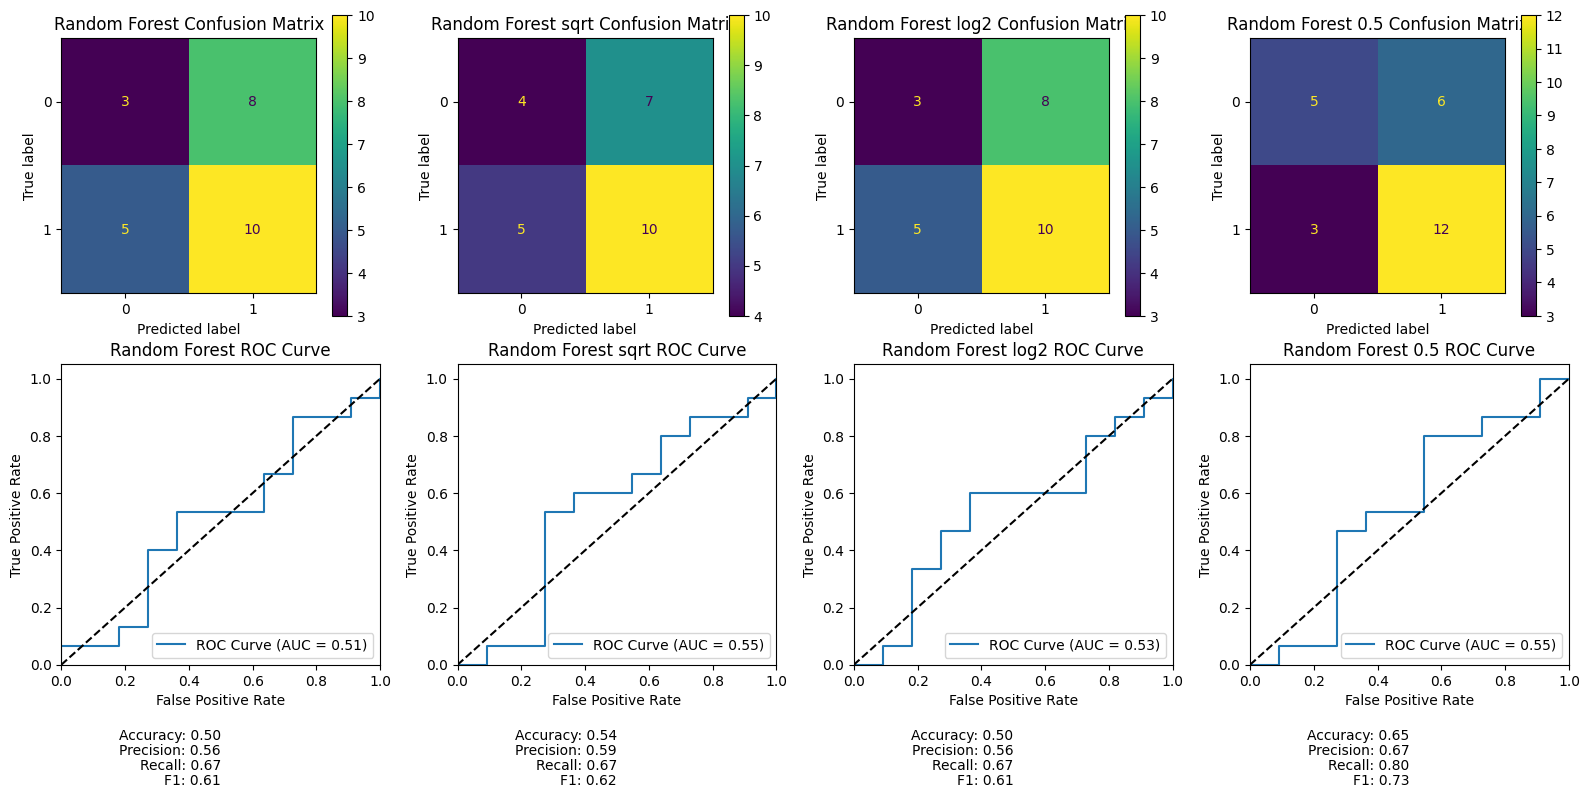

In [66]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(),
    RandomForestClassifier(max_features='sqrt'),
    RandomForestClassifier(max_features='log2'),
    RandomForestClassifier(max_features= 0.5)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest sqrt',
    'Random Forest log2',
    'Random Forest 0.5'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Minimum Samples per Leaf

In [63]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'min_samples_leaf': [1, 5, 10, 15]
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train)

Best parameters: {'min_samples_leaf': 15}
Best score: 0.59


c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

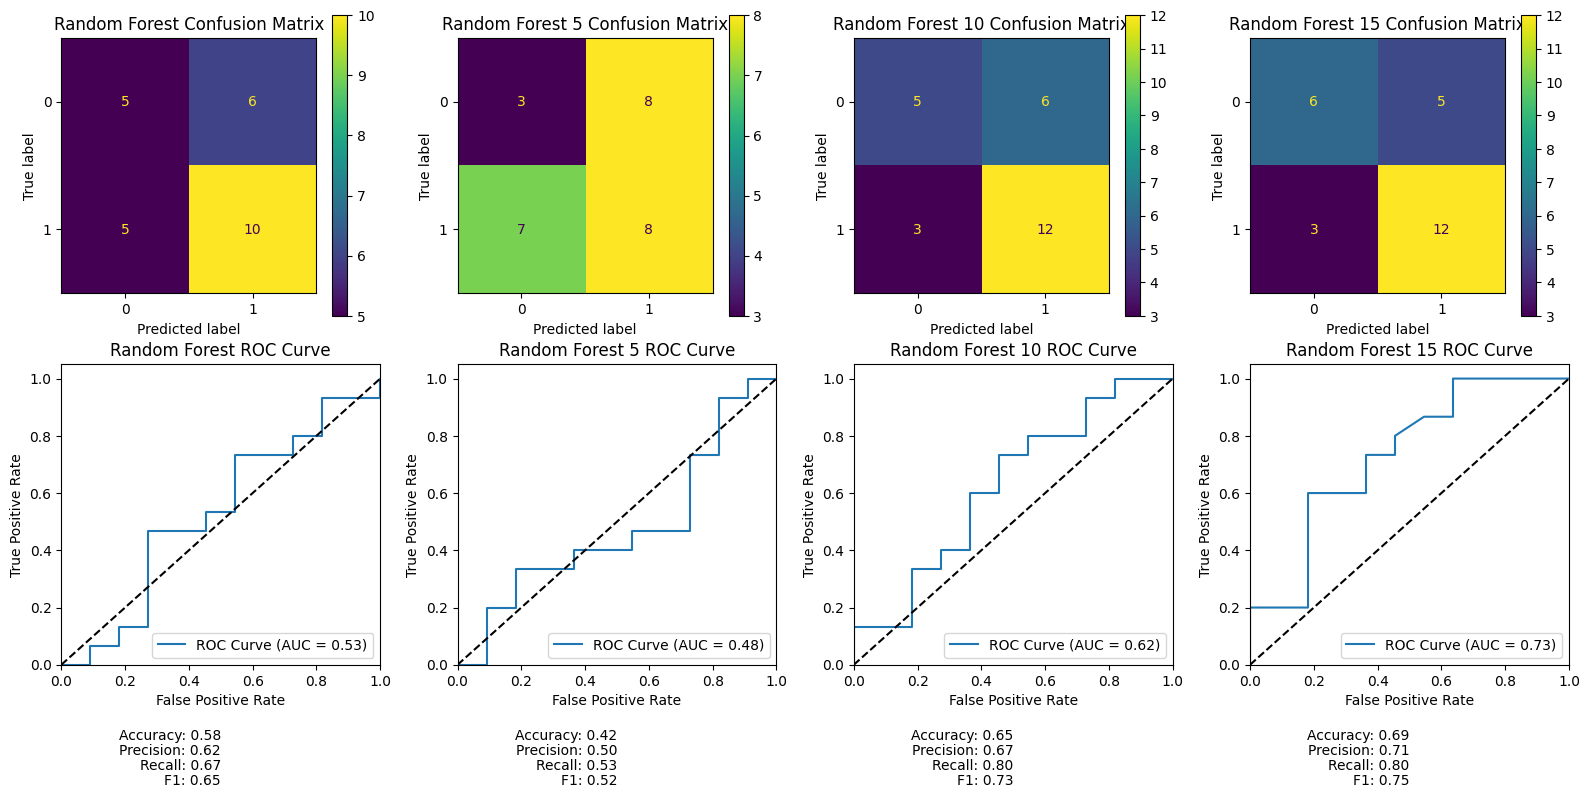

In [64]:
# Visual Method

# Initialize the models
models = [
    RandomForestClassifier(),
    RandomForestClassifier(min_samples_leaf= 5),
    RandomForestClassifier(min_samples_leaf= 10),
    RandomForestClassifier(min_samples_leaf= 15)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest 5',
    'Random Forest 10',
    'Random Forest 15'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

### Applied Optimizations

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

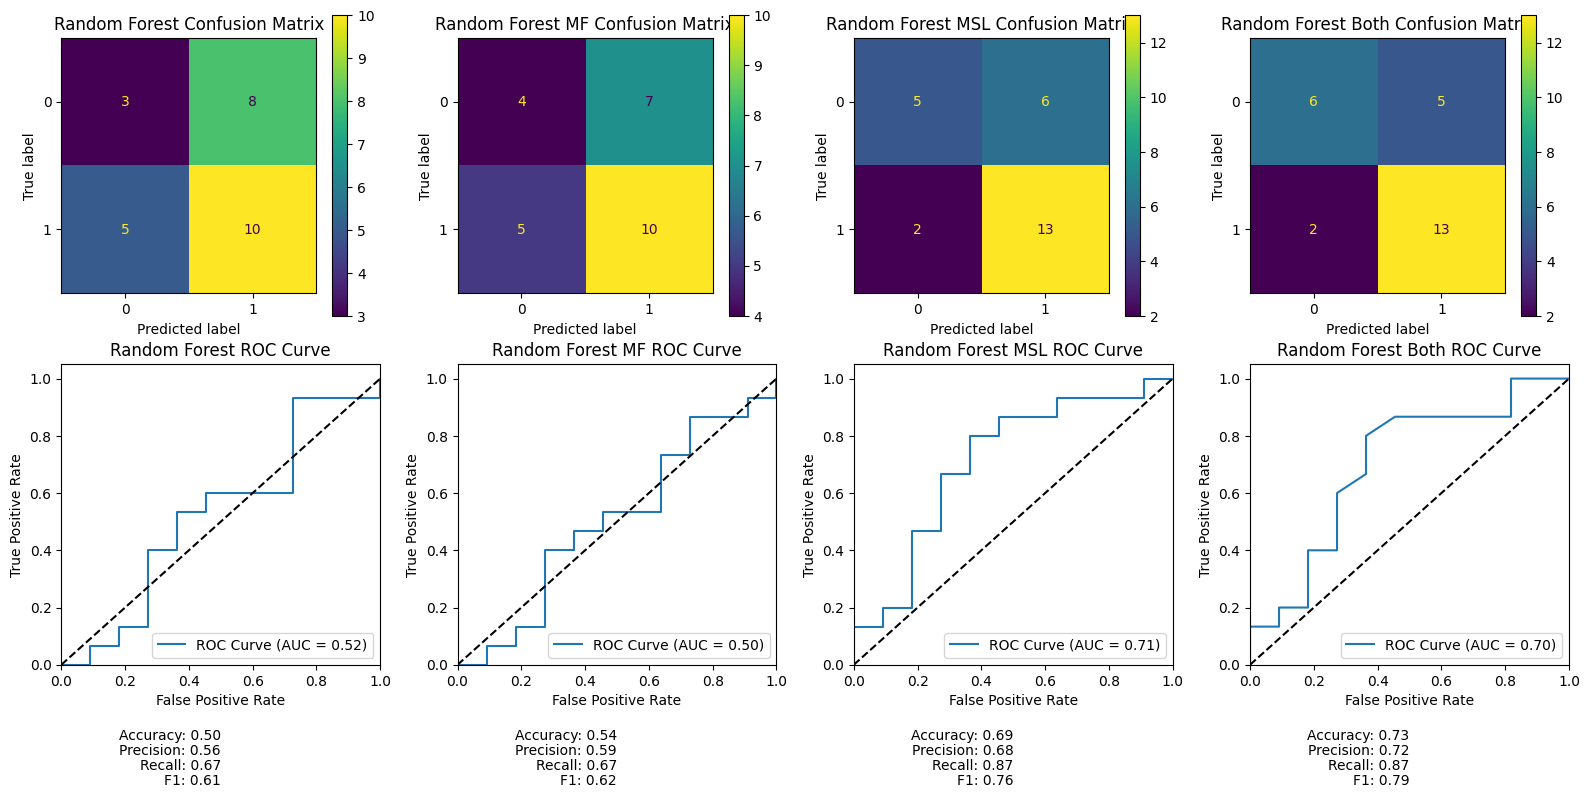

In [67]:
# Initialize the models
models = [
    RandomForestClassifier(),
    RandomForestClassifier(max_features= 0.5),
    RandomForestClassifier(min_samples_leaf= 15),
    RandomForestClassifier(max_features= 0.5, min_samples_leaf= 15)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'Random Forest MF',
    'Random Forest MSL',
    'Random Forest Both'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

#### Analysis

Each optimization adds up to positively increase our prediction metrics. Given this positive proof-of-concept, the next step will be to include more optimizations, relying on the automated attempts.

### Run More Optimizations

- Number of Trees
- Max Features
- Min Samples Split
- Minimum Samples Leaf
- Max Depth

In [87]:
# Grid Search Method

# Create a Random Forest classifier object
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 75],  # Number of trees
    'max_features': ['sqrt', 'log2', 0.5],  # Maximum features
    'min_samples_split': [2, 4, 6],  # Minimum samples split
    'min_samples_leaf': [1, 5, 10],  # Minimum samples leaf
    'max_depth': [None, 5, 7]  # Maximum depth
}

# Perform grid search optimization
optimized_model = perform_grid_search(model, param_grid, x_train, y_train)

Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 50}
Best score: 0.68


c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

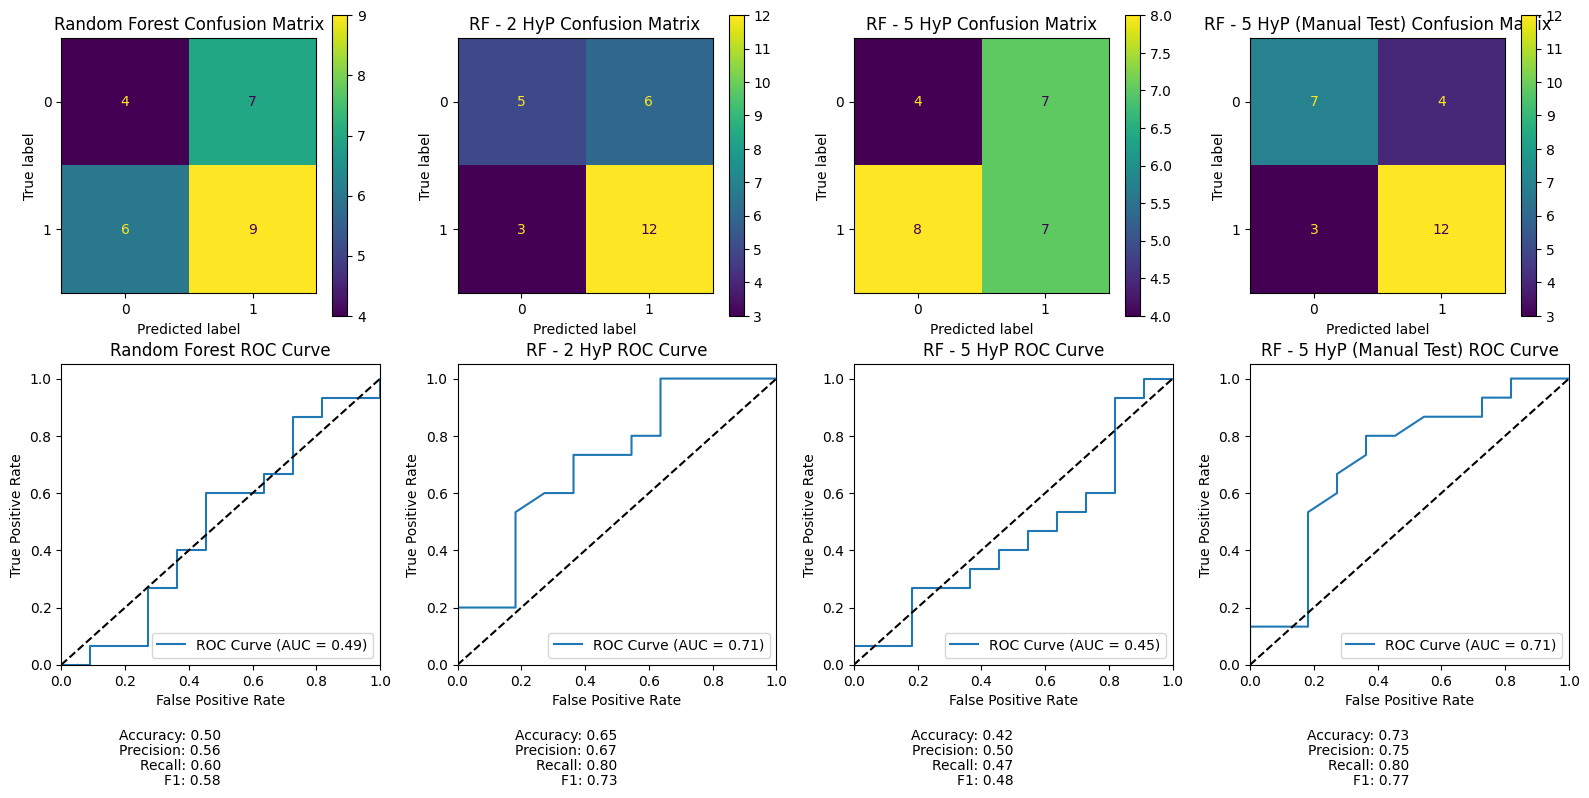

In [92]:
# Initialize the models
models = [
    RandomForestClassifier(),
    RandomForestClassifier(max_features= 0.5, min_samples_leaf= 15),
    optimized_model,
    RandomForestClassifier(n_estimators= 25, max_features= 0.5, min_samples_split= 2, min_samples_leaf= 15, max_depth= 5)
]

# Define the model names for labeling
model_names = [
    'Random Forest',
    'RF - 2 HyP',
    'RF - 5 HyP',
    'RF - 5 HyP (Manual Test)'
]

runModels(models, model_names, x_train, x_test, y_train, y_test)

#### Analysis

When tuning only 2 parameters (Max Features and Min Samples Leaf), the results are increased, but when tuning 5, the results generally worsen.

**Question:** Why might this be?